# Fonction tester

This file main goal is to test function and classes for later use in training.
Is ignore entirely during the training

In [4]:
1/(1+1e-7*100000)

0.9803921568627451

In [ ]:
1/(1+1e-7*60000)

### Import Lib

In [1]:
# General Libs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import keras
import datetime
from contextlib import redirect_stdout

# Current files
from generator import AE_Generator,
from preprocess import ProdKernel, FKernel, VarSuppression, Zero_One,  Level_Normalizer, Normalizer, DictPrepross
from generator import FC_Generator

from utils import Load_FLX_dict, Plot_Batch
from CST import CST

data_folder=  'Data2'#sCST.Data_folder(CST)
model_folder = CST.Model_folder(CST)
log_folder = CST.Log_folder(CST)

Using TensorFlow backend.
/usr/lib/python3/dist-packages/requests/__init__.py:80: RequestsDependencyWarning: urllib3 (1.24.2) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


### Prepross

In [2]:
seed=0
batch_size=32
np.random.seed(seed)
D = [Load_FLX_dict()]
FP =[]
train_generator =  AE_Generator(folder=data_folder, batch_size=batch_size, train=True, 
                                         preprocess_x=FP, chosen_var=['flxd','flxu'], stash_x=True,shuffle=1)
validation_generator = AE_Generator(folder='Data', batch_size=batch_size, train=False, 
                                             preprocess_x=FP, chosen_var=['flxd','flxu'], stash_x=True, shuffle=1, custom_b_p_e= 500)

x,y = train_generator[0]
header_x = train_generator.new_variables_pred
header_y = train_generator.new_variables_pred
in_channel=len(header_x)
o_channel = len(header_y)
lev=72

### Model construct

In [3]:
from architectures import AE, Unet_Act_Double
import keras
from architectures_simples import Upsampler, Divide_Recombine
from architectures import Unet_Act_Simple,  Bidir_Casual_Conv
from architectures_simples import Upsampler
from architectures_utils import total_loss, flxd_loss, flxu_loss, dfdts_loss, LossHistory,  Generate_Log
from keras.layers import Dense, Flatten, Reshape

import keras.backend as K
from keras import optimizers
from keras.layers import Dropout
import datetime

lev=72


list_of_filters_ae =  [[5, 18], 
                       [30, 30, 50, 50, 100, 100], 
                       [40, 20, 10], 
                       [50, 50, 100, 100, 100, 100], 
                       [10]]

list_of_kernel_ae =  [[10, 5], 
                      [2, 5, 2, 5, 2, 4], 
                      [], 
                      [3, 4, 3, 5, 3, 6], 
                      [5]]

list_of_activations_ae =  [['relu', 'relu'], 
                           ['relu', 'relu','relu','relu','relu','relu'], 
                           ['relu', 'relu','relu'], 
                           ['relu', 'relu', 'relu','relu', 'relu','relu'], 
                           ['relu']]

params_ae = [0.01]

M_Up = Upsampler(avg=5, pooling=22, input_shape=(lev, in_channel))
M_unet =  AE(list_of_kernel_ae, list_of_filters_ae, list_of_activations_ae,
                         params_ae, Div=3, lev=CST.lev(CST), in_channel=in_channel)

M_f = Divide_Recombine(o_channel, list_of_filters_ae[-1][-1], lev=lev)

M = keras.models.Sequential()
M.add(M_Up); M.layers[-1].name = 'Upsampler'
M.add(M_unet); M.layers[-1].name = 'Unet'
M.add(M_f); M.layers[-1].name = 'Div_Rec'

/home/victor/Documents/Stage/FLXmodel/FLX_NN_emulation/architectures_simples.py:29: UserWarning: Update your `AveragePooling1D` call to the Keras 2 API: `AveragePooling1D(22, padding="same", strides=5)`
  Avg = AveragePooling1D(pooling, padding='same', stride=avg)(Up)
/home/victor/Documents/Stage/FLXmodel/FLX_NN_emulation/architectures.py:196: UserWarning: Update your `MaxPooling1D` call to the Keras 2 API: `MaxPooling1D(2, padding="same", name="AVG_100", strides=2)`
  Conv_l1.append(MaxPooling1D(2, padding='same', stride=2, name=Name('AVG', i+100))(Conv_l1[-1]))
/home/victor/Documents/Stage/FLXmodel/FLX_NN_emulation/architectures.py:196: UserWarning: Update your `MaxPooling1D` call to the Keras 2 API: `MaxPooling1D(2, padding="same", name="AVG_101", strides=2)`
  Conv_l1.append(MaxPooling1D(2, padding='same', stride=2, name=Name('AVG', i+100))(Conv_l1[-1]))
/home/victor/Documents/Stage/FLXmodel/FLX_NN_emulation/architectures.py:196: UserWarning: Update your `MaxPooling1D` call to the 

In [4]:
M.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Upsampler (Model)            (None, 72, 2)             0         
_________________________________________________________________
Unet (Model)                 (None, 72, 10)            642504    
_________________________________________________________________
Div_Rec (Model)              (None, 72, 2)             103824    
Total params: 746,328
Trainable params: 746,328
Non-trainable params: 0
_________________________________________________________________


In [5]:
from keras import optimizers
from keras.losses import mean_squared_error
from architectures_utils import LossHistory, Generate_Log
import datetime

def Up_Down_loss(y_true, y_pred):
    E = flxd_loss(y_true, y_pred)
    E += flxu_loss(y_true, y_pred)
    return E

ES = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, restore_best_weights=True, baseline=35)
prefix = datetime.datetime.now().strftime("%Y%m%d%H%M%S")
archi = "AE"

LH = LossHistory(frequency=train_generator.batch_per_file, losses=['loss', 'flxd_loss', 'flxu_loss'])
Adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1.e-6, amsgrad=False)
M.compile(loss=Up_Down_loss, optimizer=Adam, metrics=[flxd_loss,flxu_loss])
M.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Upsampler (Model)            (None, 72, 2)             0         
_________________________________________________________________
Unet (Model)                 (None, 72, 10)            642504    
_________________________________________________________________
Div_Rec (Model)              (None, 72, 2)             103824    
Total params: 746,328
Trainable params: 746,328
Non-trainable params: 0
_________________________________________________________________


In [6]:
M.fit_generator(train_generator, validation_data=validation_generator, callbacks=[LH], shuffle=False,epochs=1)

Epoch 1/1
97200/97200 [==============================] - 1426s 15ms/step - loss: 3.2160 - flxd_loss: 1.7073 - flxu_loss: 0.9405 - val_loss: 2.5194 - val_flxd_loss: 1.2937 - val_flxu_loss: 0.9308


In [7]:
#2.76

In [8]:
# IMPORTANT MODEL LOG SAVER

file = os.path.join(log_folder, prefix+archi+'.txt')
M.save_weights(os.path.join(model_folder, prefix+archi))
with open(file, 'w') as f:
    with redirect_stdout(f):
        print('Seed {}'.format(seed))
        print('Optimizer')
        print(Adam.get_config())
        print('Prepross')
        for P in FP:
            print(P)
        M.summary
        for i, model in enumerate(M.layers):
            if( str(type(model)) == '<class \'keras.engine.training.Model\'>'):
                model.summary()
#        for k in history.history.keys():
#            print(k,':', history.history[k])
        print('\n')
        print('Unet')
        print('list_of_filters_unet = ',list_of_filters_ae)
        print('list_of_kernel_unet = ',list_of_kernel_ae)
        print('list_of_activation_unet = ', list_of_activations_ae)
        for loss in LH.losses:
            print(loss)
            print(LH.losses[loss])

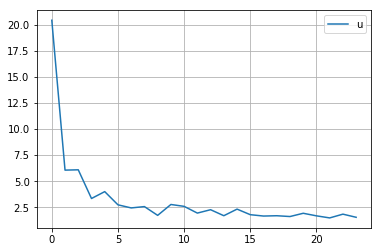

In [9]:
flxd_loss_h = LH.losses['loss'][1:-1].copy()
#flxd_loss_h = LH.losses['flxd_loss'][1:-1].copy()
#dfdts_loss_h = LH.losses['dfdts_loss'].copy()*0
#flxu_loss_h[12]*=0
#flxu_loss_h[13]*=0
#flxu_loss_h[13]*=0

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(flxd_loss_h)
#ax.plot(flxu_loss_h)
#ax.plot(dfdts_loss_h)
ax.grid()
#ax.plot(loss)
#ax.set_yscale('log')
ax.legend(['u','d', 'dtf']);

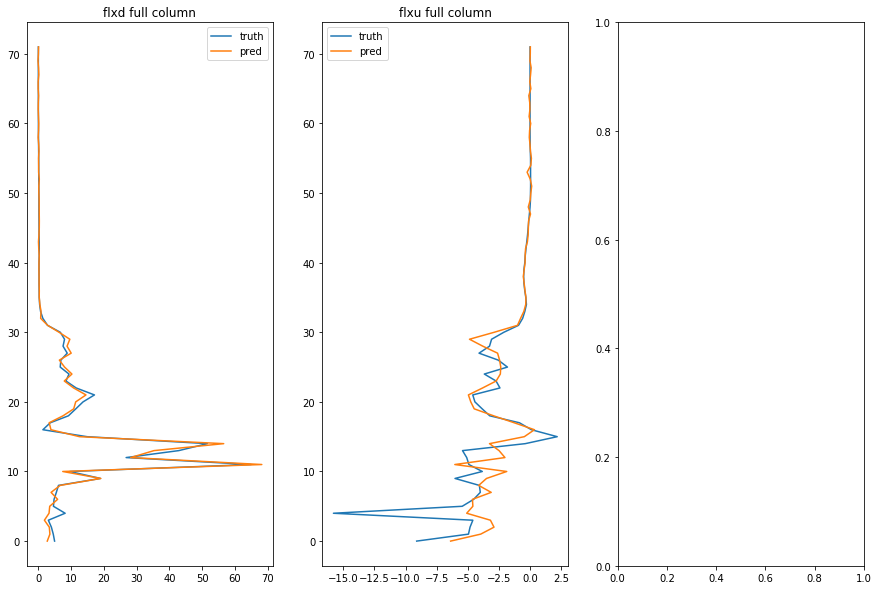

<Figure size 1080x576 with 0 Axes>

In [13]:
from utils import F_and_plots, Plot_triple_diff_separated

x,y = validation_generator[0]
y0=M.predict(y)
Plot_triple_diff_separated(F_and_plots((1,3)), y, y0,header_y, j=31)

In [48]:
L=[]
validation_generator.max_b = validation_generator.batch_per_file
from tqdm import tqdm_notebook as tqdm

for x,y in tqdm(validation_generator):
    y0 = M.predict(x)
    L.append(K.get_value(Loss(y,y0)))




  0%|          | 0/3888 [00:00<?, ?it/s]


  0%|          | 1/3888 [00:00<07:44,  8.37it/s]


  0%|          | 2/3888 [00:00<07:42,  8.40it/s]


  0%|          | 3/3888 [00:00<07:40,  8.43it/s]


  0%|          | 4/3888 [00:00<07:41,  8.42it/s]


  0%|          | 5/3888 [00:00<07:42,  8.40it/s]


  0%|          | 6/3888 [00:00<07:43,  8.37it/s]


  0%|          | 7/3888 [00:00<07:56,  8.15it/s]


  0%|          | 8/3888 [00:00<07:58,  8.11it/s]


  0%|          | 9/3888 [00:01<08:01,  8.05it/s]


  0%|          | 10/3888 [00:01<08:02,  8.03it/s]


  0%|          | 11/3888 [00:01<08:03,  8.02it/s]


  0%|          | 12/3888 [00:01<08:05,  7.99it/s]


  0%|          | 13/3888 [00:01<07:58,  8.10it/s]


  0%|          | 14/3888 [00:01<07:54,  8.17it/s]


  0%|          | 15/3888 [00:01<08:00,  8.07it/s]


  0%|          | 16/3888 [00:01<07:57,  8.12it/s]


  0%|          | 17/3888 [00:02<08:02,  8.02it/s]


  0%|          | 18/3888 [00:02<08:00,  8.05it/s]


  0%|          | 19/3888 [0

  3%|▎         | 134/3888 [00:17<08:10,  7.65it/s]


  3%|▎         | 135/3888 [00:17<08:21,  7.48it/s]


  3%|▎         | 136/3888 [00:17<08:52,  7.04it/s]


  4%|▎         | 137/3888 [00:17<08:49,  7.08it/s]


  4%|▎         | 138/3888 [00:17<08:43,  7.16it/s]


  4%|▎         | 139/3888 [00:18<08:37,  7.24it/s]


  4%|▎         | 140/3888 [00:18<08:28,  7.37it/s]


  4%|▎         | 141/3888 [00:18<08:26,  7.40it/s]


  4%|▎         | 142/3888 [00:18<08:22,  7.45it/s]


  4%|▎         | 143/3888 [00:18<08:20,  7.48it/s]


  4%|▎         | 144/3888 [00:18<08:18,  7.52it/s]


  4%|▎         | 145/3888 [00:18<08:23,  7.44it/s]


  4%|▍         | 146/3888 [00:18<08:22,  7.45it/s]


  4%|▍         | 147/3888 [00:19<08:23,  7.44it/s]


  4%|▍         | 148/3888 [00:19<08:16,  7.53it/s]


  4%|▍         | 149/3888 [00:19<08:12,  7.59it/s]


  4%|▍         | 150/3888 [00:19<08:09,  7.63it/s]


  4%|▍         | 151/3888 [00:19<08:06,  7.68it/s]


  4%|▍         | 152/3888 [00:19<08:10,  7.61i

 10%|█         | 398/3888 [00:57<09:52,  5.89it/s]


 10%|█         | 399/3888 [00:57<09:33,  6.09it/s]


 10%|█         | 400/3888 [00:57<09:18,  6.25it/s]


 10%|█         | 401/3888 [00:57<09:21,  6.21it/s]


 10%|█         | 402/3888 [00:57<09:22,  6.20it/s]


 10%|█         | 403/3888 [00:57<09:29,  6.12it/s]


 10%|█         | 404/3888 [00:58<09:45,  5.95it/s]


 10%|█         | 405/3888 [00:58<09:46,  5.93it/s]


 10%|█         | 406/3888 [00:58<09:39,  6.01it/s]


 10%|█         | 407/3888 [00:58<09:38,  6.01it/s]


 10%|█         | 408/3888 [00:58<09:25,  6.15it/s]


 11%|█         | 409/3888 [00:58<09:22,  6.18it/s]


 11%|█         | 410/3888 [00:59<09:20,  6.20it/s]


 11%|█         | 411/3888 [00:59<09:17,  6.24it/s]


 11%|█         | 412/3888 [00:59<09:22,  6.18it/s]


 11%|█         | 413/3888 [00:59<09:30,  6.10it/s]


 11%|█         | 414/3888 [00:59<09:24,  6.15it/s]


 11%|█         | 415/3888 [00:59<09:15,  6.26it/s]


 11%|█         | 416/3888 [00:59<09:13,  6.27i

 17%|█▋        | 662/3888 [01:42<09:37,  5.59it/s]


 17%|█▋        | 663/3888 [01:42<09:41,  5.54it/s]


 17%|█▋        | 664/3888 [01:42<09:35,  5.60it/s]


 17%|█▋        | 665/3888 [01:42<09:34,  5.61it/s]


 17%|█▋        | 666/3888 [01:42<09:34,  5.61it/s]


 17%|█▋        | 667/3888 [01:43<09:33,  5.62it/s]


 17%|█▋        | 668/3888 [01:43<09:29,  5.66it/s]


 17%|█▋        | 669/3888 [01:43<09:33,  5.61it/s]


 17%|█▋        | 670/3888 [01:43<09:33,  5.62it/s]


 17%|█▋        | 671/3888 [01:43<09:33,  5.61it/s]


 17%|█▋        | 672/3888 [01:43<09:34,  5.60it/s]


 17%|█▋        | 673/3888 [01:44<09:35,  5.58it/s]


 17%|█▋        | 674/3888 [01:44<09:46,  5.48it/s]


 17%|█▋        | 675/3888 [01:44<09:46,  5.48it/s]


 17%|█▋        | 676/3888 [01:44<09:44,  5.50it/s]


 17%|█▋        | 677/3888 [01:44<09:41,  5.52it/s]


 17%|█▋        | 678/3888 [01:45<09:42,  5.51it/s]


 17%|█▋        | 679/3888 [01:45<09:40,  5.52it/s]


 17%|█▋        | 680/3888 [01:45<09:45,  5.48i

 24%|██▍       | 926/3888 [02:33<10:17,  4.80it/s]


 24%|██▍       | 927/3888 [02:33<10:20,  4.78it/s]


 24%|██▍       | 928/3888 [02:34<10:36,  4.65it/s]


 24%|██▍       | 929/3888 [02:34<10:33,  4.67it/s]


 24%|██▍       | 930/3888 [02:34<10:32,  4.68it/s]


 24%|██▍       | 931/3888 [02:34<10:23,  4.74it/s]


 24%|██▍       | 932/3888 [02:34<10:21,  4.76it/s]


 24%|██▍       | 933/3888 [02:35<10:19,  4.77it/s]


 24%|██▍       | 934/3888 [02:35<10:16,  4.79it/s]


 24%|██▍       | 935/3888 [02:35<10:17,  4.79it/s]


 24%|██▍       | 936/3888 [02:35<10:27,  4.70it/s]


 24%|██▍       | 937/3888 [02:35<10:28,  4.69it/s]


 24%|██▍       | 938/3888 [02:36<10:21,  4.74it/s]


 24%|██▍       | 939/3888 [02:36<10:21,  4.74it/s]


 24%|██▍       | 940/3888 [02:36<10:25,  4.71it/s]


 24%|██▍       | 941/3888 [02:36<10:33,  4.65it/s]


 24%|██▍       | 942/3888 [02:37<10:31,  4.67it/s]


 24%|██▍       | 943/3888 [02:37<10:32,  4.66it/s]


 24%|██▍       | 944/3888 [02:37<10:45,  4.56i

 31%|███       | 1187/3888 [03:30<10:18,  4.37it/s]


 31%|███       | 1188/3888 [03:31<10:19,  4.36it/s]


 31%|███       | 1189/3888 [03:31<10:17,  4.37it/s]


 31%|███       | 1190/3888 [03:31<10:15,  4.38it/s]


 31%|███       | 1191/3888 [03:31<10:14,  4.39it/s]


 31%|███       | 1192/3888 [03:32<10:17,  4.37it/s]


 31%|███       | 1193/3888 [03:32<10:21,  4.34it/s]


 31%|███       | 1194/3888 [03:32<10:09,  4.42it/s]


 31%|███       | 1195/3888 [03:32<10:09,  4.42it/s]


 31%|███       | 1196/3888 [03:32<10:13,  4.39it/s]


 31%|███       | 1197/3888 [03:33<10:21,  4.33it/s]


 31%|███       | 1198/3888 [03:33<10:19,  4.34it/s]


 31%|███       | 1199/3888 [03:33<10:20,  4.34it/s]


 31%|███       | 1200/3888 [03:33<10:23,  4.31it/s]


 31%|███       | 1201/3888 [03:34<10:30,  4.26it/s]


 31%|███       | 1202/3888 [03:34<10:29,  4.27it/s]


 31%|███       | 1203/3888 [03:34<10:25,  4.29it/s]


 31%|███       | 1204/3888 [03:34<10:22,  4.31it/s]


 31%|███       | 1205/3888 [

 37%|███▋      | 1447/3888 [04:34<10:49,  3.76it/s]


 37%|███▋      | 1448/3888 [04:34<10:57,  3.71it/s]


 37%|███▋      | 1449/3888 [04:34<11:14,  3.62it/s]


 37%|███▋      | 1450/3888 [04:35<11:08,  3.65it/s]


 37%|███▋      | 1451/3888 [04:35<11:12,  3.62it/s]


 37%|███▋      | 1452/3888 [04:35<11:17,  3.59it/s]


 37%|███▋      | 1453/3888 [04:36<11:05,  3.66it/s]


 37%|███▋      | 1454/3888 [04:36<11:03,  3.67it/s]


 37%|███▋      | 1455/3888 [04:36<10:59,  3.69it/s]


 37%|███▋      | 1456/3888 [04:36<10:54,  3.72it/s]


 37%|███▋      | 1457/3888 [04:37<10:45,  3.77it/s]


 38%|███▊      | 1458/3888 [04:37<10:46,  3.76it/s]


 38%|███▊      | 1459/3888 [04:37<10:51,  3.73it/s]


 38%|███▊      | 1460/3888 [04:37<10:35,  3.82it/s]


 38%|███▊      | 1461/3888 [04:38<10:48,  3.74it/s]


 38%|███▊      | 1462/3888 [04:38<10:58,  3.68it/s]


 38%|███▊      | 1463/3888 [04:38<11:16,  3.59it/s]


 38%|███▊      | 1464/3888 [04:38<10:59,  3.68it/s]


 38%|███▊      | 1465/3888 [

 44%|████▍     | 1707/3888 [05:45<10:27,  3.47it/s]


 44%|████▍     | 1708/3888 [05:46<10:35,  3.43it/s]


 44%|████▍     | 1709/3888 [05:46<10:36,  3.42it/s]


 44%|████▍     | 1710/3888 [05:46<10:34,  3.43it/s]


 44%|████▍     | 1711/3888 [05:47<10:29,  3.46it/s]


 44%|████▍     | 1712/3888 [05:47<10:25,  3.48it/s]


 44%|████▍     | 1713/3888 [05:47<10:21,  3.50it/s]


 44%|████▍     | 1714/3888 [05:48<10:21,  3.50it/s]


 44%|████▍     | 1715/3888 [05:48<10:25,  3.47it/s]


 44%|████▍     | 1716/3888 [05:48<10:19,  3.51it/s]


 44%|████▍     | 1717/3888 [05:48<10:22,  3.49it/s]


 44%|████▍     | 1718/3888 [05:49<10:21,  3.49it/s]


 44%|████▍     | 1719/3888 [05:49<10:21,  3.49it/s]


 44%|████▍     | 1720/3888 [05:49<10:14,  3.53it/s]


 44%|████▍     | 1721/3888 [05:50<10:13,  3.53it/s]


 44%|████▍     | 1722/3888 [05:50<10:11,  3.54it/s]


 44%|████▍     | 1723/3888 [05:50<10:10,  3.54it/s]


 44%|████▍     | 1724/3888 [05:50<10:07,  3.56it/s]


 44%|████▍     | 1725/3888 [

 51%|█████     | 1967/3888 [07:04<09:38,  3.32it/s]


 51%|█████     | 1968/3888 [07:04<09:37,  3.33it/s]


 51%|█████     | 1969/3888 [07:04<09:33,  3.35it/s]


 51%|█████     | 1970/3888 [07:04<09:33,  3.34it/s]


 51%|█████     | 1971/3888 [07:05<09:48,  3.26it/s]


 51%|█████     | 1972/3888 [07:05<09:53,  3.23it/s]


 51%|█████     | 1973/3888 [07:05<09:48,  3.25it/s]


 51%|█████     | 1974/3888 [07:06<09:49,  3.25it/s]


 51%|█████     | 1975/3888 [07:06<09:45,  3.27it/s]


 51%|█████     | 1976/3888 [07:06<09:45,  3.27it/s]


 51%|█████     | 1977/3888 [07:07<09:46,  3.26it/s]


 51%|█████     | 1978/3888 [07:07<09:49,  3.24it/s]


 51%|█████     | 1979/3888 [07:07<09:46,  3.25it/s]


 51%|█████     | 1980/3888 [07:08<09:46,  3.25it/s]


 51%|█████     | 1981/3888 [07:08<09:47,  3.25it/s]


 51%|█████     | 1982/3888 [07:08<09:46,  3.25it/s]


 51%|█████     | 1983/3888 [07:08<09:46,  3.25it/s]


 51%|█████     | 1984/3888 [07:09<09:50,  3.22it/s]


 51%|█████     | 1985/3888 [

 57%|█████▋    | 2227/3888 [08:27<09:43,  2.84it/s]


 57%|█████▋    | 2228/3888 [08:27<09:40,  2.86it/s]


 57%|█████▋    | 2229/3888 [08:28<09:38,  2.87it/s]


 57%|█████▋    | 2230/3888 [08:28<09:55,  2.78it/s]


 57%|█████▋    | 2231/3888 [08:29<09:55,  2.78it/s]


 57%|█████▋    | 2232/3888 [08:29<09:50,  2.80it/s]


 57%|█████▋    | 2233/3888 [08:29<09:48,  2.81it/s]


 57%|█████▋    | 2234/3888 [08:30<09:38,  2.86it/s]


 57%|█████▋    | 2235/3888 [08:30<09:32,  2.88it/s]


 58%|█████▊    | 2236/3888 [08:30<09:31,  2.89it/s]


 58%|█████▊    | 2237/3888 [08:31<09:29,  2.90it/s]


 58%|█████▊    | 2238/3888 [08:31<09:24,  2.92it/s]


 58%|█████▊    | 2239/3888 [08:31<09:24,  2.92it/s]


 58%|█████▊    | 2240/3888 [08:32<09:25,  2.92it/s]


 58%|█████▊    | 2241/3888 [08:32<09:27,  2.90it/s]


 58%|█████▊    | 2242/3888 [08:32<09:30,  2.88it/s]


 58%|█████▊    | 2243/3888 [08:33<09:35,  2.86it/s]


 58%|█████▊    | 2244/3888 [08:33<09:33,  2.87it/s]


 58%|█████▊    | 2245/3888 [

 64%|██████▍   | 2487/3888 [09:58<08:32,  2.73it/s]


 64%|██████▍   | 2488/3888 [09:58<08:37,  2.71it/s]


 64%|██████▍   | 2489/3888 [09:59<08:57,  2.60it/s]


 64%|██████▍   | 2490/3888 [09:59<09:06,  2.56it/s]


 64%|██████▍   | 2491/3888 [10:00<09:11,  2.53it/s]


 64%|██████▍   | 2492/3888 [10:00<09:11,  2.53it/s]


 64%|██████▍   | 2493/3888 [10:00<09:01,  2.58it/s]


 64%|██████▍   | 2494/3888 [10:01<08:52,  2.62it/s]


 64%|██████▍   | 2495/3888 [10:01<08:50,  2.62it/s]


 64%|██████▍   | 2496/3888 [10:02<08:44,  2.65it/s]


 64%|██████▍   | 2497/3888 [10:02<08:50,  2.62it/s]


 64%|██████▍   | 2498/3888 [10:02<08:44,  2.65it/s]


 64%|██████▍   | 2499/3888 [10:03<08:46,  2.64it/s]


 64%|██████▍   | 2500/3888 [10:03<08:49,  2.62it/s]


 64%|██████▍   | 2501/3888 [10:03<08:41,  2.66it/s]


 64%|██████▍   | 2502/3888 [10:04<08:41,  2.66it/s]


 64%|██████▍   | 2503/3888 [10:04<08:45,  2.63it/s]


 64%|██████▍   | 2504/3888 [10:05<08:51,  2.60it/s]


 64%|██████▍   | 2505/3888 [

 71%|███████   | 2747/3888 [11:46<07:55,  2.40it/s]


 71%|███████   | 2748/3888 [11:47<08:00,  2.37it/s]


 71%|███████   | 2749/3888 [11:47<07:59,  2.37it/s]


 71%|███████   | 2750/3888 [11:48<07:59,  2.37it/s]


 71%|███████   | 2751/3888 [11:48<07:56,  2.39it/s]


 71%|███████   | 2752/3888 [11:49<07:57,  2.38it/s]


 71%|███████   | 2753/3888 [11:49<07:53,  2.40it/s]


 71%|███████   | 2754/3888 [11:49<07:49,  2.42it/s]


 71%|███████   | 2755/3888 [11:50<07:57,  2.37it/s]


 71%|███████   | 2756/3888 [11:50<07:57,  2.37it/s]


 71%|███████   | 2757/3888 [11:51<07:58,  2.37it/s]


 71%|███████   | 2758/3888 [11:51<07:51,  2.40it/s]


 71%|███████   | 2759/3888 [11:51<07:44,  2.43it/s]


 71%|███████   | 2760/3888 [11:52<07:36,  2.47it/s]


 71%|███████   | 2761/3888 [11:52<07:41,  2.44it/s]


 71%|███████   | 2762/3888 [11:53<07:38,  2.46it/s]


 71%|███████   | 2763/3888 [11:53<07:40,  2.44it/s]


 71%|███████   | 2764/3888 [11:54<07:37,  2.45it/s]


 71%|███████   | 2765/3888 [

 77%|███████▋  | 3007/3888 [13:38<06:33,  2.24it/s]


 77%|███████▋  | 3008/3888 [13:39<06:29,  2.26it/s]


 77%|███████▋  | 3009/3888 [13:39<06:31,  2.24it/s]


 77%|███████▋  | 3010/3888 [13:40<06:37,  2.21it/s]


 77%|███████▋  | 3011/3888 [13:40<06:26,  2.27it/s]


 77%|███████▋  | 3012/3888 [13:41<06:20,  2.30it/s]


 77%|███████▋  | 3013/3888 [13:41<06:14,  2.33it/s]


 78%|███████▊  | 3014/3888 [13:41<06:13,  2.34it/s]


 78%|███████▊  | 3015/3888 [13:42<06:14,  2.33it/s]


 78%|███████▊  | 3016/3888 [13:42<06:22,  2.28it/s]


 78%|███████▊  | 3017/3888 [13:43<06:23,  2.27it/s]


 78%|███████▊  | 3018/3888 [13:43<06:25,  2.25it/s]


 78%|███████▊  | 3019/3888 [13:44<06:24,  2.26it/s]


 78%|███████▊  | 3020/3888 [13:44<06:22,  2.27it/s]


 78%|███████▊  | 3021/3888 [13:44<06:25,  2.25it/s]


 78%|███████▊  | 3022/3888 [13:45<06:20,  2.28it/s]


 78%|███████▊  | 3023/3888 [13:45<06:16,  2.30it/s]


 78%|███████▊  | 3024/3888 [13:46<06:14,  2.31it/s]


 78%|███████▊  | 3025/3888 [

 84%|████████▍ | 3267/3888 [15:38<04:50,  2.14it/s]


 84%|████████▍ | 3268/3888 [15:38<04:50,  2.14it/s]


 84%|████████▍ | 3269/3888 [15:39<04:44,  2.18it/s]


 84%|████████▍ | 3270/3888 [15:39<04:43,  2.18it/s]


 84%|████████▍ | 3271/3888 [15:40<04:43,  2.18it/s]


 84%|████████▍ | 3272/3888 [15:40<04:45,  2.16it/s]


 84%|████████▍ | 3273/3888 [15:41<04:41,  2.18it/s]


 84%|████████▍ | 3274/3888 [15:41<04:39,  2.20it/s]


 84%|████████▍ | 3275/3888 [15:42<04:38,  2.20it/s]


 84%|████████▍ | 3276/3888 [15:42<04:49,  2.11it/s]


 84%|████████▍ | 3277/3888 [15:43<05:00,  2.03it/s]


 84%|████████▍ | 3278/3888 [15:43<05:00,  2.03it/s]


 84%|████████▍ | 3279/3888 [15:44<04:58,  2.04it/s]


 84%|████████▍ | 3280/3888 [15:44<05:00,  2.02it/s]


 84%|████████▍ | 3281/3888 [15:45<05:00,  2.02it/s]


 84%|████████▍ | 3282/3888 [15:45<05:04,  1.99it/s]


 84%|████████▍ | 3283/3888 [15:46<05:00,  2.01it/s]


 84%|████████▍ | 3284/3888 [15:46<05:00,  2.01it/s]


 84%|████████▍ | 3285/3888 [

 91%|█████████ | 3527/3888 [17:46<03:08,  1.92it/s]


 91%|█████████ | 3528/3888 [17:47<03:06,  1.93it/s]


 91%|█████████ | 3529/3888 [17:47<03:01,  1.98it/s]


 91%|█████████ | 3530/3888 [17:48<03:06,  1.92it/s]


 91%|█████████ | 3531/3888 [17:48<03:07,  1.91it/s]


 91%|█████████ | 3532/3888 [17:49<03:04,  1.93it/s]


 91%|█████████ | 3533/3888 [17:49<03:04,  1.92it/s]


 91%|█████████ | 3534/3888 [17:50<03:03,  1.93it/s]


 91%|█████████ | 3535/3888 [17:50<03:02,  1.93it/s]


 91%|█████████ | 3536/3888 [17:51<03:03,  1.92it/s]


 91%|█████████ | 3537/3888 [17:51<03:02,  1.92it/s]


 91%|█████████ | 3538/3888 [17:52<03:04,  1.89it/s]


 91%|█████████ | 3539/3888 [17:52<03:03,  1.90it/s]


 91%|█████████ | 3540/3888 [17:53<02:58,  1.94it/s]


 91%|█████████ | 3541/3888 [17:53<02:55,  1.97it/s]


 91%|█████████ | 3542/3888 [17:54<02:55,  1.97it/s]


 91%|█████████ | 3543/3888 [17:54<02:53,  1.99it/s]


 91%|█████████ | 3544/3888 [17:55<02:56,  1.95it/s]


 91%|█████████ | 3545/3888 [

 97%|█████████▋| 3787/3888 [20:08<00:57,  1.77it/s]


 97%|█████████▋| 3788/3888 [20:08<00:56,  1.77it/s]


 97%|█████████▋| 3789/3888 [20:09<00:55,  1.78it/s]


 97%|█████████▋| 3790/3888 [20:09<00:54,  1.79it/s]


 98%|█████████▊| 3791/3888 [20:10<00:54,  1.78it/s]


 98%|█████████▊| 3792/3888 [20:10<00:53,  1.79it/s]


 98%|█████████▊| 3793/3888 [20:11<00:53,  1.79it/s]


 98%|█████████▊| 3794/3888 [20:12<00:52,  1.79it/s]


 98%|█████████▊| 3795/3888 [20:12<00:51,  1.79it/s]


 98%|█████████▊| 3796/3888 [20:13<00:51,  1.79it/s]


 98%|█████████▊| 3797/3888 [20:13<00:51,  1.77it/s]


 98%|█████████▊| 3798/3888 [20:14<00:50,  1.77it/s]


 98%|█████████▊| 3799/3888 [20:14<00:49,  1.81it/s]


 98%|█████████▊| 3800/3888 [20:15<00:48,  1.83it/s]


 98%|█████████▊| 3801/3888 [20:15<00:47,  1.85it/s]


 98%|█████████▊| 3802/3888 [20:16<00:46,  1.85it/s]


 98%|█████████▊| 3803/3888 [20:16<00:46,  1.84it/s]


 98%|█████████▊| 3804/3888 [20:17<00:46,  1.82it/s]


 98%|█████████▊| 3805/3888 [

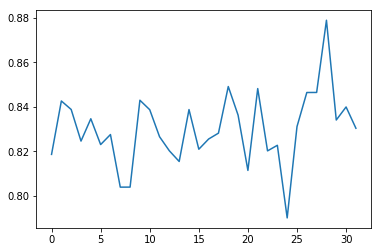

In [49]:
L=np.array(L)
plt.plot(np.mean(L, axis=0))

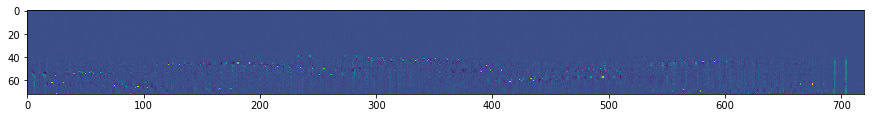

In [18]:
w=M_f.get_layer('Last_Dense_0').get_weights()
f= plt.figure(figsize=(15,30))
plt.imshow(w[0].T)

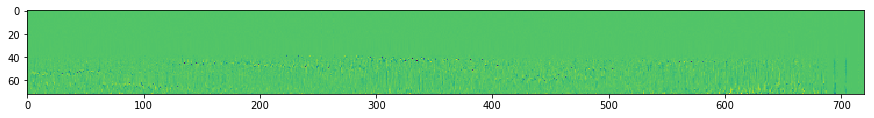

In [19]:
w=M_f.get_layer('Last_Dense_1').get_weights()
f= plt.figure(figsize=(15,30))
plt.imshow(w[0].T)